In [233]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from lib import tiles3 as tc
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [234]:
env = gym.envs.make("MountainCar-v0")

In [235]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurized representation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [236]:
# Tile Coding Class
# Source: https://github.com/MikeS96/rl_openai/blob/master/Mountain%20Car.ipynb
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.6
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input
        # The max position is set to 0.5 as this is the position to end the experiment
        POSITION_MIN = -1.2
        POSITION_MAX = 0.5
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07
        
        # Scale position and velocity by multiplying the inputs of each by their scale
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        
        # Obtain active tiles for current position and velocity
        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale])
        
        return np.array(tiles)
    def get_feature_vector(self, position, velocity):
        """Similar to the above function but reture the one-hot feature vector instead"""
        active_tiles = self.get_tiles(position, velocity)
        feature_vec = np.zeros(self.iht.size)
        feature_vec[active_tiles] = 1
        return feature_vec

In [237]:
mctc = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)

In [238]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, used_tile_coding = False):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        self.used_tile_coding = used_tile_coding
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # if self.used_tile_coding:                
            #     model = SGDRegressor(learning_rate="constant", eta0=1./mctc.num_tilings)
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            # Note 19/12/2023: the env.reset() do not return value like env.observation_space.sample()
            # Don't know why but it returns a tuple observation, {} so we need to take the first element.            
            model.partial_fit([self.featurize_state(env.reset()[0])], [0])
            self.models.append(model)
                    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """                
        if self.used_tile_coding:
            return mctc.get_feature_vector(state[0], state[1])
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]    
    
    def featurize_state_tile_coding(self, state):
        """
        Returns the featurized tile-coding representation for a state.
        """                
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]    
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        # TODO: Implement this!
        if a is None:                        
            return np.array([self.models[a].predict([self.featurize_state(s)])[0] for a in range(env.action_space.n)])
        return self.models[a].predict([self.featurize_state(s)])[0]        
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
        self.models[a].partial_fit([self.featurize_state(s)], [y])                
        return None

In [239]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA        
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [240]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="\n")
        sys.stdout.flush()
        
        # TODO: Implement this!
        cur_state = env.reset()[0]
        while True:
            #Pick action according to current Q vals using epsilon greedy            
            policy_vals = policy(cur_state)
            cur_action = np.random.choice(len(policy_vals), p = policy_vals)
            nxt_state, reward, is_lst, _,_ = env.step(cur_action)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1
                        
            #print(stats.episode_lengths[i_episode], estimator.predict(nxt_state))
            target = reward + discount_factor*np.max(estimator.predict(nxt_state))
            estimator.update(cur_state, cur_action, target)
            if is_lst:
                break            
            cur_state = nxt_state
    return stats

# Tile Coding

In [241]:
estimator = Estimator(used_tile_coding=True)

In [242]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 100, epsilon=0.0)

Episode 1/100 (0.0)


c:\Users\qapham\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 2/100 (-7126.0)
Episode 3/100 (-1975.0)
Episode 4/100 (-1161.0)
Episode 5/100 (-1118.0)
Episode 6/100 (-986.0)
Episode 7/100 (-1015.0)
Episode 8/100 (-802.0)
Episode 9/100 (-568.0)
Episode 10/100 (-793.0)
Episode 11/100 (-655.0)
Episode 12/100 (-679.0)
Episode 13/100 (-674.0)
Episode 14/100 (-649.0)
Episode 15/100 (-654.0)
Episode 16/100 (-622.0)
Episode 17/100 (-579.0)
Episode 18/100 (-669.0)
Episode 19/100 (-706.0)
Episode 20/100 (-409.0)
Episode 21/100 (-568.0)
Episode 22/100 (-394.0)
Episode 23/100 (-437.0)
Episode 24/100 (-515.0)
Episode 25/100 (-461.0)
Episode 26/100 (-325.0)
Episode 27/100 (-393.0)
Episode 28/100 (-461.0)
Episode 29/100 (-541.0)
Episode 30/100 (-321.0)
Episode 31/100 (-361.0)
Episode 32/100 (-523.0)
Episode 33/100 (-501.0)
Episode 34/100 (-345.0)
Episode 35/100 (-544.0)
Episode 36/100 (-320.0)
Episode 37/100 (-442.0)
Episode 38/100 (-415.0)
Episode 39/100 (-285.0)
Episode 40/100 (-298.0)
Episode 41/100 (-281.0)
Episode 42/100 (-509.0)
Episode 43/100 (-31

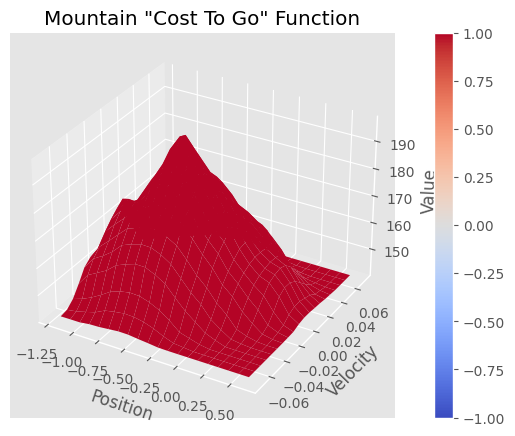

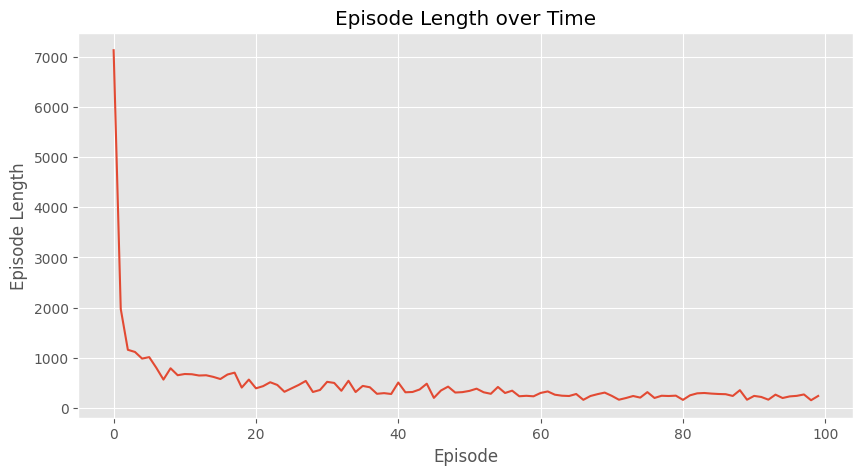

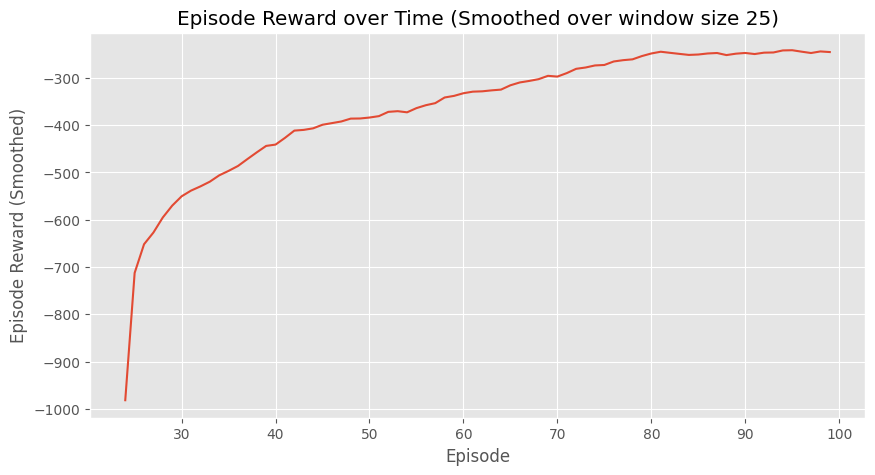

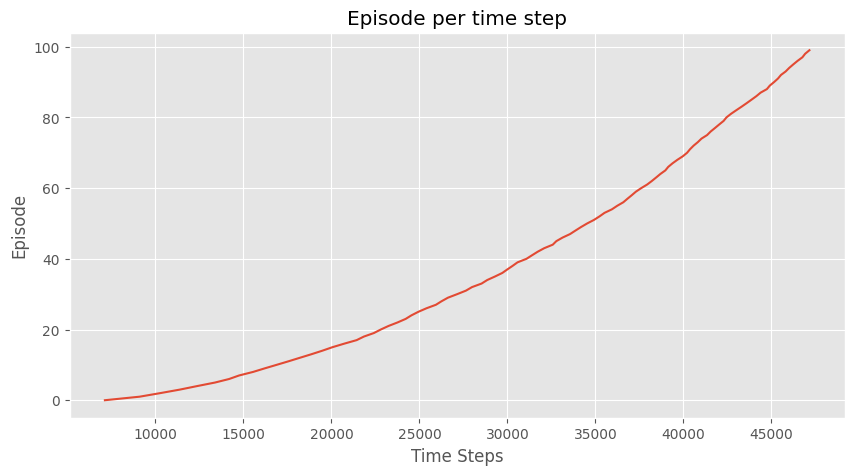

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [243]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

# Featurizing with Sampling

In [230]:
estimator = Estimator()

In [231]:
stats = q_learning(env, estimator, 100, epsilon=0.0)

Episode 1/100 (0.0)
Episode 2/100 (-3573.0)
Episode 3/100 (-1678.0)
Episode 4/100 (-738.0)
Episode 5/100 (-810.0)
Episode 6/100 (-563.0)
Episode 7/100 (-578.0)
Episode 8/100 (-236.0)
Episode 9/100 (-423.0)
Episode 10/100 (-520.0)
Episode 11/100 (-322.0)
Episode 12/100 (-325.0)
Episode 13/100 (-335.0)
Episode 14/100 (-352.0)
Episode 15/100 (-238.0)
Episode 16/100 (-315.0)
Episode 17/100 (-402.0)
Episode 18/100 (-263.0)
Episode 19/100 (-229.0)
Episode 20/100 (-274.0)
Episode 21/100 (-256.0)
Episode 22/100 (-332.0)
Episode 23/100 (-149.0)
Episode 24/100 (-239.0)
Episode 25/100 (-263.0)
Episode 26/100 (-262.0)
Episode 27/100 (-194.0)
Episode 28/100 (-145.0)
Episode 29/100 (-256.0)
Episode 30/100 (-154.0)
Episode 31/100 (-156.0)
Episode 32/100 (-228.0)
Episode 33/100 (-240.0)
Episode 34/100 (-218.0)
Episode 35/100 (-147.0)
Episode 36/100 (-148.0)
Episode 37/100 (-157.0)
Episode 38/100 (-154.0)
Episode 39/100 (-242.0)
Episode 40/100 (-183.0)
Episode 41/100 (-153.0)
Episode 42/100 (-155.0)
Ep

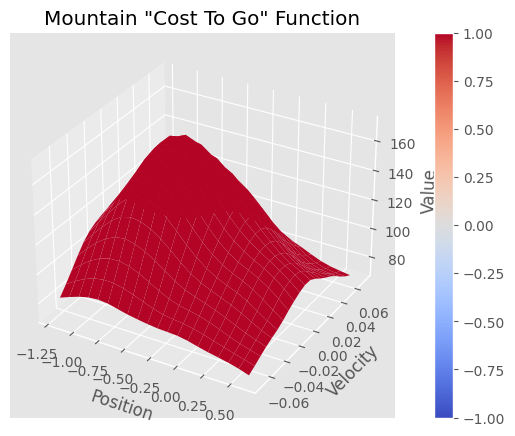

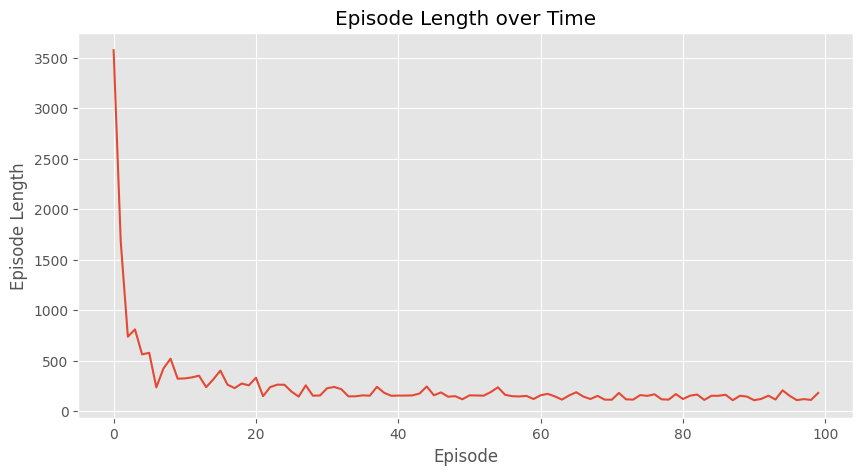

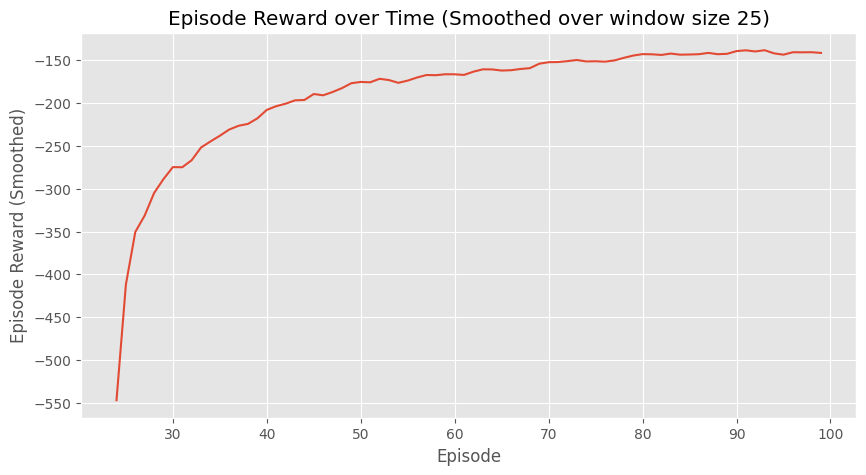

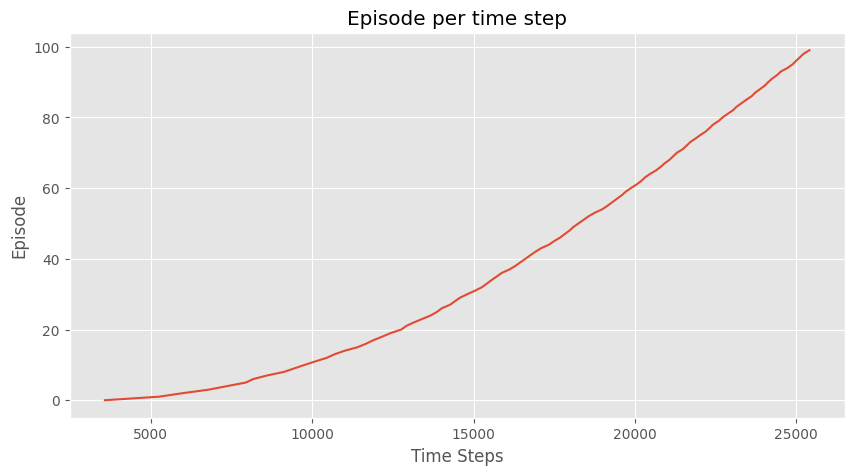

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [232]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)